In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *
import random

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 12
test_epoch_count = 22
batch_size = 32

T.manual_seed(seed)
random.seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, identities_weight=0.04, identitity_weight_decay=0.9)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
train epoch 00/12 | batch 2001/2000 | loss 1.1801 | val loss 0.7716 | acc 0.2131 | f1 0.3514 | prec 0.2131 | recall 1.0000 | roc auc 0.5142 | pr auc 0.2463 | elapsed 32.87s
train epoch 01/12 | batch 2001/2000 | loss 0.8689 | val loss 0.4804 | acc 0.8211 | f1 0.3921 | prec 0.7111 | recall 0.2707 | roc auc 0.6841 | pr auc 0.5091 | elapsed 93.33s
train epoch 02/12 | batch 2001/2000 | loss 0.5729 | val loss 0.3674 | acc 0.8586 | f1 0.5770 | prec 0.7962 | recall 0.4525 | roc auc 0.8276 | pr auc 0.6958 | elapsed 93.38s
train epoch 03/12 | batch 2001/2000 | loss 0.4351 | val loss 0.2976 | acc 0.8923 | f1 0.7050 | prec 0.8470 | recall 0.6038 | roc auc 0.8835 | pr auc 0.7993 | elapsed 92.00s
train epoch 04/12 | batch 2001/2000 | loss 0.3450 | val loss 0.2540 | acc 0.9127 | f1 0.7683 | prec 0.8843 | recall 0.6792 | roc auc 0.9092 | pr auc 0.8484 | elapsed 86.07s
train epoch 05/12 | batch 2001/2000 | loss 0.2841 |

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data_te[0],
    'X': data_te[1],
    'y': data_te[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2, val_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, temp_data = train_test_split(group_data, test_size=(test_size + val_size), stratify=group_data[stratify_col])
        val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size + val_size), stratify=temp_data[stratify_col])

        train_idx.extend(train_data.index)
        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[val_idx], data.loc[test_idx]

train_data, val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.2, val_size=0.2)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_te_tr = [ontology_id_train,X_train, y_train] 

X_val = val_data['X'].tolist()
y_val = val_data['y'].tolist()
ontology_id_val = val_data['ontology_id'].tolist()

data_te_vl = [ontology_id_val, X_val, y_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()


In [5]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger,identities_weight=0.045, identitity_weight_decay=0.9)
    #else:
        #train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/22 | batch 751/750 | loss 1.1925 | val loss 1.0673 | acc 0.6444 | f1 0.3986 | prec 0.3153 | recall 0.5420 | roc auc 0.6586 | pr auc 0.4966 | elapsed 11.31s
train epoch 01/22 | batch 751/750 | loss 1.0674 | val loss 0.8349 | acc 0.6985 | f1 0.4422 | prec 0.3700 | recall 0.5494 | roc auc 0.7071 | pr auc 0.5438 | elapsed 23.01s
train epoch 02/22 | batch 751/750 | loss 0.8211 | val loss 0.6576 | acc 0.7518 | f1 0.5037 | prec 0.4456 | recall 0.5793 | roc auc 0.7555 | pr auc 0.5976 | elapsed 23.96s
train epoch 03/22 | batch 751/750 | loss 0.6381 | val loss 0.5271 | acc 0.7933 | f1 0.5594 | prec 0.5214 | recall 0.6034 | roc auc 0.8009 | pr auc 0.6560 | elapsed 23.80s
train epoch 04/22 | batch 751/750 | loss 0.5033 | val loss 0.4329 | acc 0.8283 | f1 0.6162 | prec 0.5995 | recall 0.6339 | roc auc 0.8399 | pr auc 0.7137 | elapsed 24.95s
train epoch 05/22 | batch 751/750 | loss 0.4065 | val loss 0.3653 | acc 0.8565 | f1 0.6690 | prec 0.6713 | recall 0.6667 | roc a

In [6]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    #_, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240710T195046


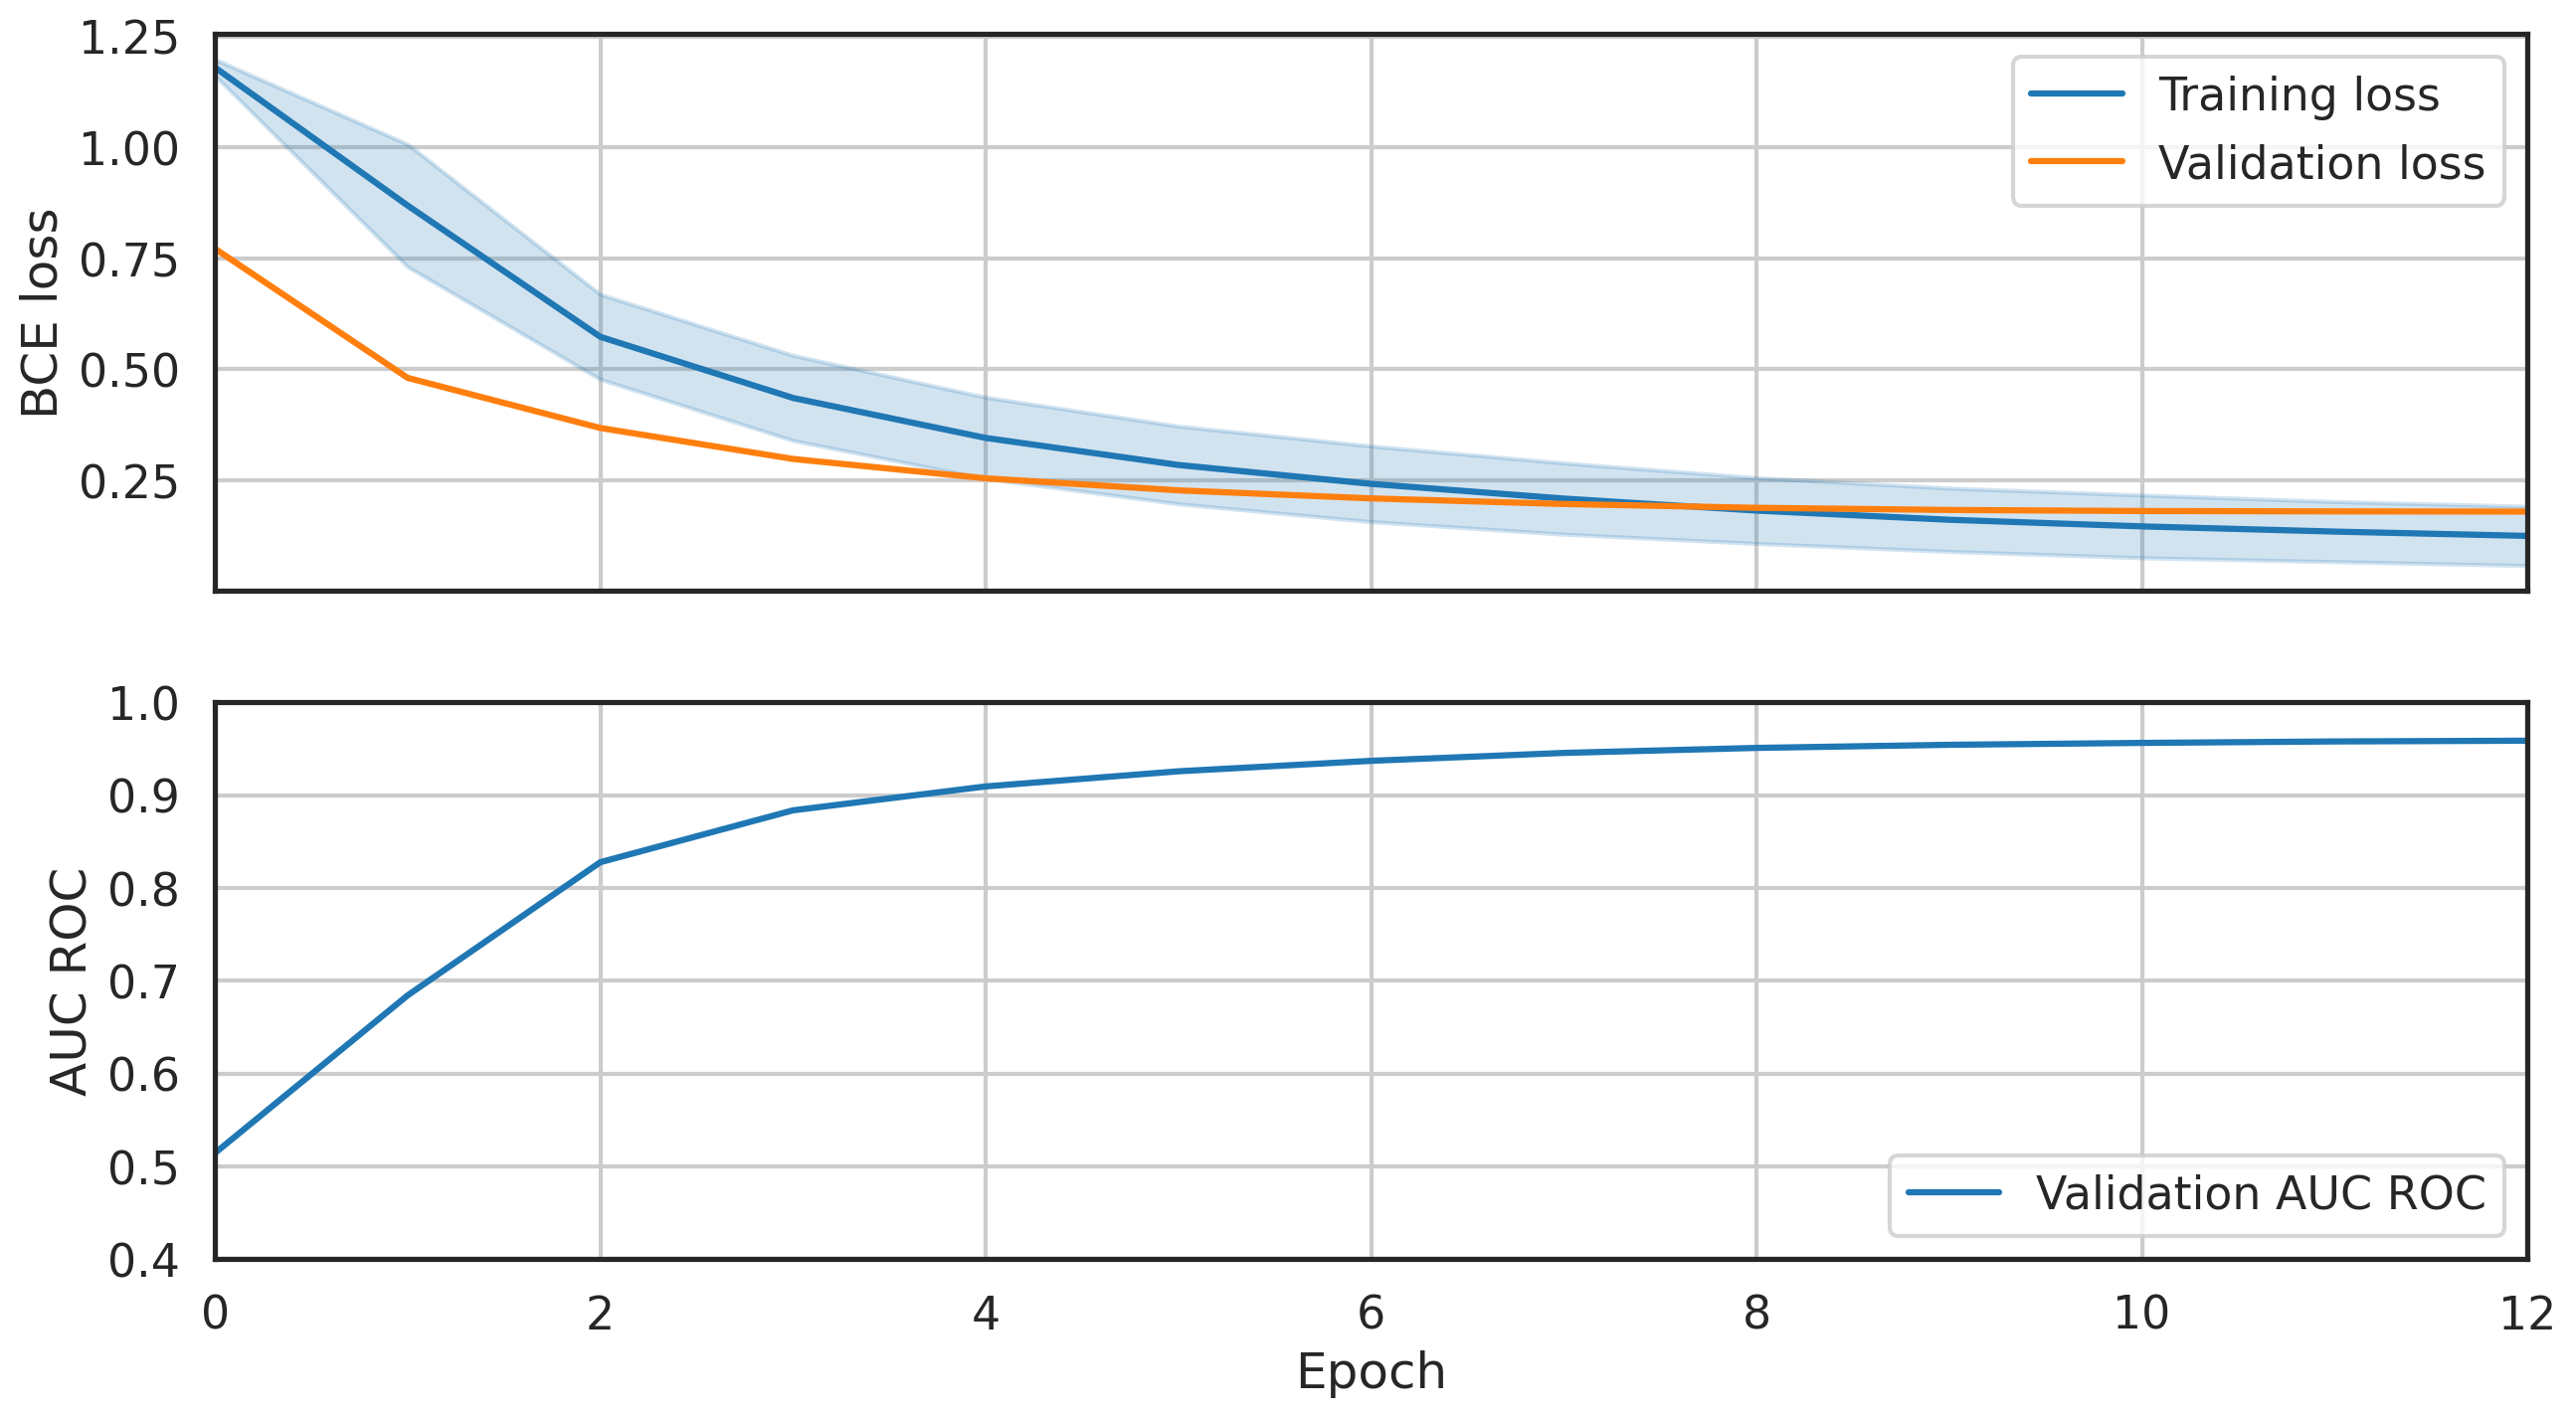

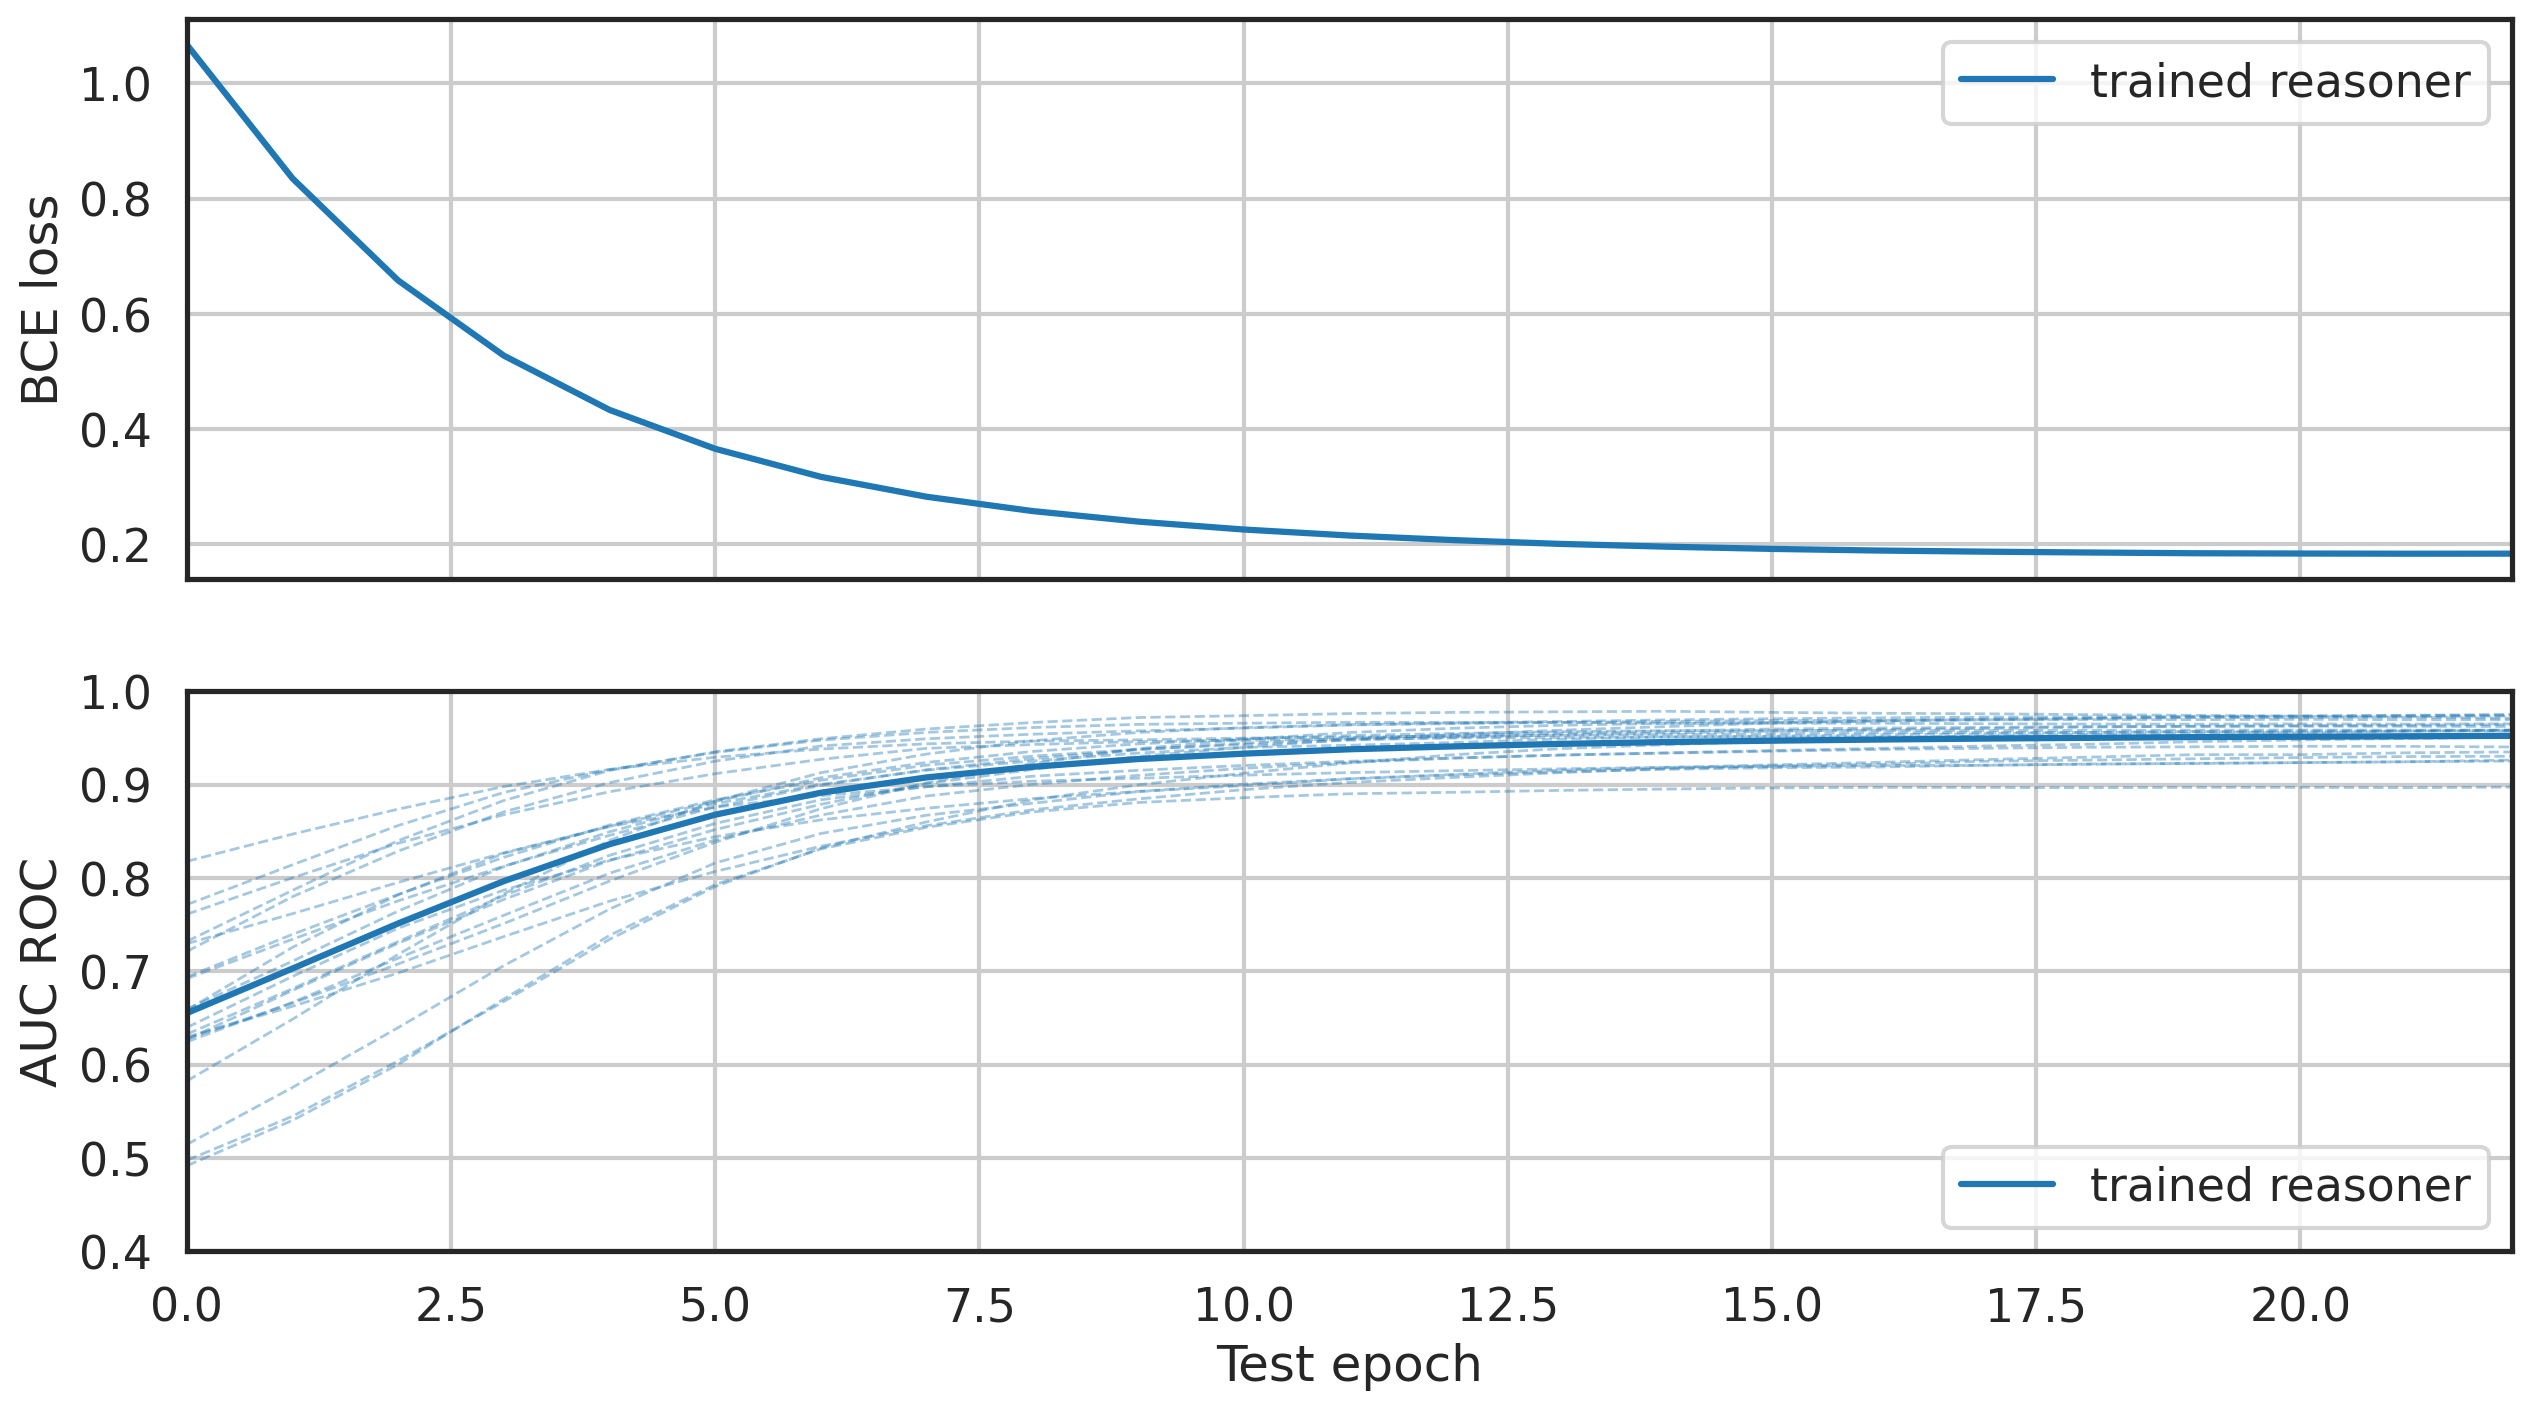

             mean       std     micro
acc      0.940500  0.021191  0.940500
prec     0.896401  0.057179  0.895429
recall   0.818815  0.060121  0.822312
f1       0.854903  0.051119  0.857314
auc_roc  0.946794  0.023310  0.948497
auc_pr   0.912547  0.035033  0.916649


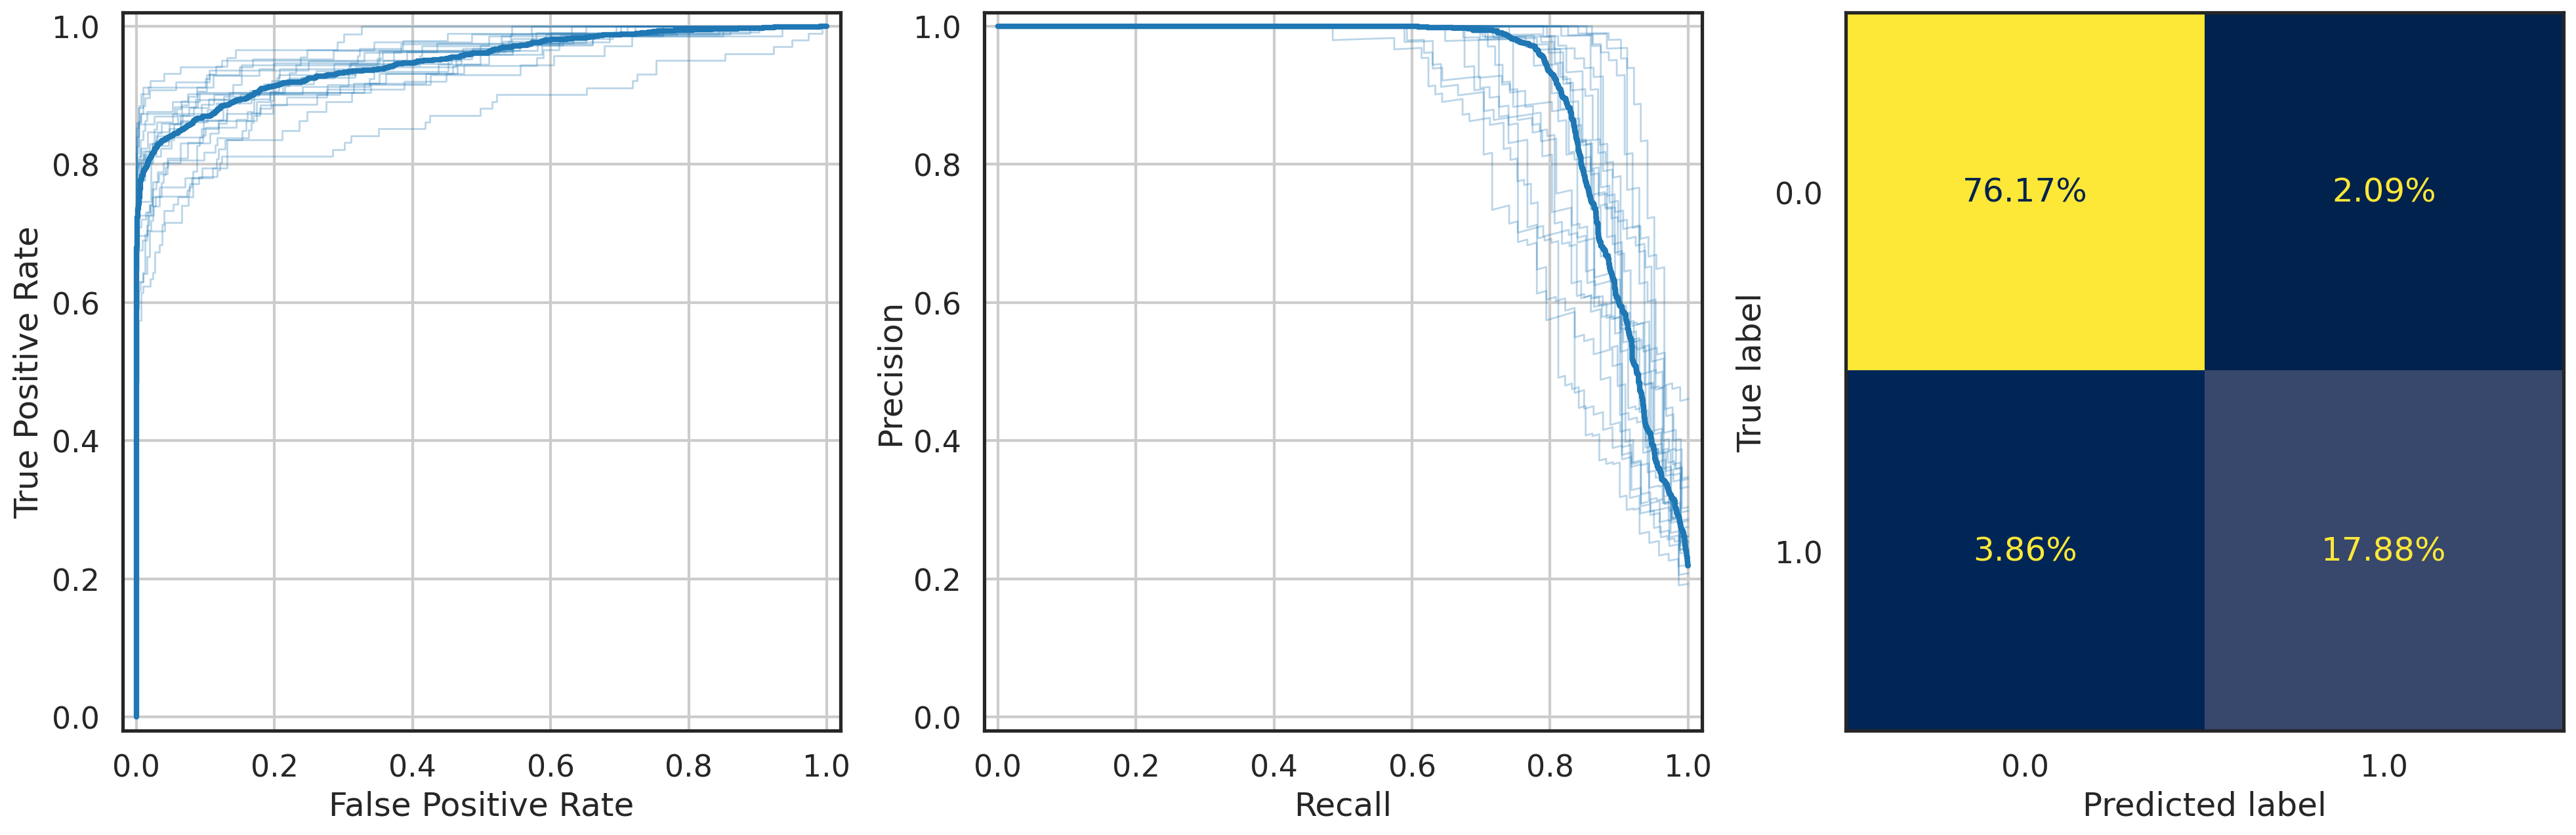

In [7]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))#, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
#print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))

In [8]:
T.set_printoptions(precision=4)

In [9]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im_mod(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im_mod( input, input)))
print(np.mean(losses))

tensor([-0.1870, -0.0570, -0.0411,  0.0005, -0.2153,  0.0102, -0.3181, -0.0308,
         0.0811,  0.0081], grad_fn=<SelectBackward0>)
tensor([-0.0172, -0.1755, -0.0802, -0.0521,  0.0082, -0.2166, -0.1940, -0.2194,
         0.1034,  0.1474], grad_fn=<AddBackward0>)
0.11513257436454297


In [10]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.3273,  0.2083,  0.1112, -0.2956,  0.3851, -0.0214,  0.1030,  0.1192,
        -0.2661, -0.1431], grad_fn=<SelectBackward0>)
tensor([ 0.3604,  0.1594,  0.1155, -0.2844,  0.3591, -0.0146,  0.0818,  0.1101,
        -0.2323, -0.1618], grad_fn=<AddBackward0>)
0.019963111262768507


In [11]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([-0.2204, -0.0444, -0.0455,  0.2908, -0.1698, -0.0243,  0.3600, -0.0078,
         0.2619,  0.0804], grad_fn=<SelectBackward0>)
tensor([-0.1511, -0.1623, -0.0240,  0.2136, -0.1531,  0.0301,  0.1140, -0.0310,
         0.1173,  0.1075], grad_fn=<AddBackward0>)
0.09179179277271032


In [12]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im_mod(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.3273,  0.2083,  0.1112, -0.2956,  0.3851, -0.0214,  0.1030,  0.1192,
        -0.2661, -0.1431], grad_fn=<SelectBackward0>)
tensor([ 0.2294,  0.1370,  0.0795, -0.2045,  0.2832,  0.0058,  0.0980,  0.0813,
        -0.1539, -0.0824], grad_fn=<AddBackward0>)
0.18482586964964867


In [13]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.3273,  0.2083,  0.1112, -0.2956,  0.3851, -0.0214,  0.1030,  0.1192,
        -0.2661, -0.1431], grad_fn=<SelectBackward0>)
tensor([ 0.3277,  0.2091,  0.1110, -0.2964,  0.3855, -0.0218,  0.1020,  0.1193,
        -0.2661, -0.1432], grad_fn=<SqueezeBackward3>)


tensor(0.0004, grad_fn=<L1LossBackward0>)


In [14]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.0732, -0.2746, -0.0425,  0.3955,  0.0424,  0.2287,  0.7704,  0.0268,
        -0.1138,  0.3599], grad_fn=<SelectBackward0>)
tensor([-0.0731, -0.2741, -0.0419,  0.3953,  0.0424,  0.2286,  0.7695,  0.0271,
        -0.1139,  0.3592], grad_fn=<SqueezeBackward3>)
tensor(0.0003, grad_fn=<L1LossBackward0>)


In [15]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))), trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))))
print(trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.0651, -0.0652,  0.0437, -0.1426,  0.0856, -0.1127, -0.0695, -0.0859,
        -0.0012,  0.0404], grad_fn=<AddBackward0>)
tensor([ 0.0950, -0.0828,  0.0479, -0.1251,  0.1034, -0.1535, -0.0979, -0.0914,
         0.0074,  0.0361], grad_fn=<AddBackward0>)
0.02231683568097651


In [16]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im_mod(input1, input2)), trained_reasoner.and_nn(im_mod(input2, input1))).item())

print(trained_reasoner.and_nn(im_mod(input1, input2)))
print(trained_reasoner.and_nn(im_mod(input2, input1)))

print(np.mean(losses))

tensor([ 0.0360, -0.1245,  0.0454, -0.0953,  0.0567, -0.1702, -0.1274, -0.1369,
         0.0449,  0.1082], grad_fn=<AddBackward0>)
tensor([ 0.0299, -0.1222, -0.0148, -0.0966,  0.0522, -0.1576, -0.1223, -0.1118,
         0.0278,  0.0680], grad_fn=<AddBackward0>)
0.021500537474639713


In [17]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([ 0.2641,  0.1196,  0.2543, -0.5141,  0.1143,  0.1477,  0.0998,  0.0297,
        -0.2141, -0.1277], grad_fn=<SelectBackward0>)
tensor([ 0.2465,  0.1923,  0.1895, -0.3267,  0.2475,  0.0752,  0.0843,  0.0956,
        -0.2265, -0.1735], grad_fn=<AddBackward0>)
0.07339682523161173


In [18]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9994727164506912


In [19]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.999983549118042


In [20]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.999983549118042
